<a href="https://colab.research.google.com/github/Pro-Mentor/ml-model/blob/main/extract_skills_from_job_descriptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Skills from Job Descriptions

This project consists of finding a correlation between job descriptions and skills.

We will focus on the following jobs:

*   Software Engineer
*   QA Engineer
*   UI/UX Engineer
*   Project Manager
*   Data Engineer
*   DevOps Engineer
*   ML Engineer

## 1. Problem Definition

> How well can we predict the desired IT job role based on given skills?



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O

# to preprocess text data
import string
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('wordnet')

import nltk
from nltk.corpus import stopwords

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 2. Data

The data is extracted from couple of datasets available in Kaggle platform.

1. [US Software Engineer Jobs](https://www.kaggle.com/datasets/mexwell/us-software-engineer-jobs)
2. [US based Technology Jobs](https://www.kaggle.com/code/rayjohnsoncomedy/job-skills/input?select=dice_com-job_us_sample.csv)
3. [Data Engineer Jobs](https://www.kaggle.com/code/samruddhim/analysis-of-data-engineer-jobs/input)
4. [Online Job Postings](https://www.kaggle.com/code/tusharsarkar/it-job-recommendation/input?select=data+job+posts.csv)

In [ ]:
# read csv files of finalized job descriptions
software_engineers = pd.read_csv('/content/drive/MyDrive/FYP/datasets/final-job-descriptions/software-engineer.csv')
qa_engineers = pd.read_csv('/content/drive/MyDrive/FYP/datasets/final-job-descriptions/qa-engineer.csv')
uiux_engineers = pd.read_csv('/content/drive/MyDrive/FYP/datasets/final-job-descriptions/uiux-engineer.csv')
project_managers = pd.read_csv('/content/drive/MyDrive/FYP/datasets/final-job-descriptions/project-manager.csv')
data_engineers = pd.read_csv('/content/drive/MyDrive/FYP/datasets/final-job-descriptions/data-engineer.csv')
devops_engineers = pd.read_csv('/content/drive/MyDrive/FYP/datasets/final-job-descriptions/devops-engineer.csv')
ml_engineers = pd.read_csv('/content/drive/MyDrive/FYP/datasets/final-job-descriptions/ml-engineer.csv')

# get the number of rows in each job
se_rows = software_engineers.shape[0]
qa_rows = qa_engineers.shape[0]
ui_rows = uiux_engineers.shape[0]
pm_rows = project_managers.shape[0]
de_rows = data_engineers.shape[0]
do_rows = devops_engineers.shape[0]
ml_rows = ml_engineers.shape[0]

# print the number of rows
print("Number of total job descriptions")
print(f"Software Engineer : {se_rows}")
print(f"QA Engineer : {qa_rows}")
print(f"UI/UX Engineer : {ui_rows}")
print(f"Project Manager : {pm_rows}")
print(f"Data Engineer : {de_rows}")
print(f"DevOps Engineer : {do_rows}")
print(f"ML Engineer : {ml_rows}")

Number of total job descriptions
Software Engineer : 1047
QA Engineer : 445
UI/UX Engineer : 406
Project Manager : 408
Data Engineer : 645
DevOps Engineer : 1055
ML Engineer : 347




*   The least number of job descriptions are available for ML engineer job role.
*    So, we can create a seperate dataset randomly combining job descriptions of all the above job roles of **around 350 data rows from each**.


In [ ]:
# getting random sample datasets of 350 rows from each other than ML engineers
software_engineers = software_engineers.sample(n=350, random_state=42)
qa_engineers = qa_engineers.sample(n=350, random_state=42)
uiux_engineers = uiux_engineers.sample(n=350, random_state=42)
project_managers = project_managers.sample(n=350, random_state=42)
data_engineers = data_engineers.sample(n=350, random_state=42)
devops_engineers = devops_engineers.sample(n=350, random_state=42)

# get the number of rows in each job
se_rows = software_engineers.shape[0]
qa_rows = qa_engineers.shape[0]
ui_rows = uiux_engineers.shape[0]
pm_rows = project_managers.shape[0]
de_rows = data_engineers.shape[0]
do_rows = devops_engineers.shape[0]
ml_rows = ml_engineers.shape[0]

# print the number of rows
print("Number of rows in Random Sample Datasets")
print(f"Software Engineer : {se_rows}")
print(f"QA Engineer : {qa_rows}")
print(f"UI/UX Engineer : {ui_rows}")
print(f"Project Manager : {pm_rows}")
print(f"Data Engineer : {de_rows}")
print(f"DevOps Engineer : {do_rows}")
print(f"ML Engineer : {ml_rows}")

Number of rows in Random Sample Datasets
Software Engineer : 350
QA Engineer : 350
UI/UX Engineer : 350
Project Manager : 350
Data Engineer : 350
DevOps Engineer : 350
ML Engineer : 347


In [ ]:
# concatenate the random sample datasets into a single dataset
df = pd.concat([
    software_engineers,
    qa_engineers,
    uiux_engineers,
    project_managers,
    data_engineers,
    devops_engineers,
    ml_engineers
], ignore_index=True)

df.to_csv('/content/drive/MyDrive/FYP/datasets/final-job-descriptions/random-sample-dataset.csv', index=False)

## 3. Evaluation

## 4. Features

Getting an overall idea about the dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        2447 non-null   object
 1   description  2447 non-null   object
dtypes: object(2)
memory usage: 38.4+ KB


In [ ]:
df.head()

,title,description
0,Software Engineer,Work as a front-end engineer at the intersecti...
1,Software Engineer,"- Responsible for programming, development of ..."
2,Software Engineer,- Write PHP-MYSQL and Javascript code;\r\n- De...
3,Software Engineer,- Participate in web based applications develo...
4,Software Engineer,Knowledge in Photoshop or other graphic design...


In [ ]:
# shuffle the dataset
df = df.sample(frac=1, random_state=42)
df.head()

,title,description
2222,Machine Learning Engineer,Experience applying various machine learning t...
1228,Project Manager,The hiring manager is looking for a Project Ma...
1159,Project Manager,We are excited to introduce a Business Develop...
1957,DevOps Engineer,Acts as a liaison between the software develop...
879,UI/UX Engineer,Your involvement with these systems will be co...


In [ ]:
df.isna().sum()

title          0
description    0
dtype: int64

In [ ]:
df.head(20).T

,2222,1228,1159,1957,879,1786,1477,668,1050,2081,237,1598,422,2087,1666,2016,2273,1113,416,507
title,Machine Learning Engineer,Project Manager,Project Manager,DevOps Engineer,UI/UX Engineer,DevOps Engineer,Data Engineer,QA Engineer,Project Manager,DevOps Engineer,Software Engineer,Data Engineer,QA Engineer,DevOps Engineer,Data Engineer,DevOps Engineer,Machine Learning Engineer,Project Manager,QA Engineer,QA Engineer
description,Experience applying various machine learning t...,The hiring manager is looking for a Project Ma...,We are excited to introduce a Business Develop...,Acts as a liaison between the software develop...,Your involvement with these systems will be co...,Familiarity with regulated software systems (H...,Data Engineer\nIf you are a Data Engineer with...,The candidate needs to have strong C++ and Jav...,Are you excited about the incredible opportuni...,Develop automation that enables our developmen...,- Responsible for developing and building high...,Who are we?\n\nSense360 is a Series A startup ...,- Design and implement unit test cases on exis...,Experience using Agile software development me...,Data Engineer\n\nBigtime Entertainment Co. bui...,Lead a portfolio of diverse technology project...,Contributed to open source ML software.\n Deli...,MissionTo guide the execution effort for GSI H...,Proven work experience in software quality ass...,Must have skills to plan and schedule own work...


In [ ]:
# Check the values of different columns

# Set the display option to show all rows
pd.set_option('display.max_rows', None)

df.title.value_counts()

Project Manager              350
DevOps Engineer              350
UI/UX Engineer               350
Data Engineer                350
QA Engineer                  350
Software Engineer            350
Machine Learning Engineer    347
Name: title, dtype: int64

## 5. Preprocessing text data

Since the data we're now working with is at its rawest form, we need to preprocess it before extracting information from it.

in this step, we will:

1.  Convert all text to lower cases
2.  Delete all tabulation,spaces, and new lines
3.  Delete all numericals
4.  Delete nltk's defined stop words
5.  Lemmatize text

In [ ]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

In [ ]:
## Lower case
df_tmp['description'] = df_tmp['description'].apply(lambda x: " ".join(x.lower()for x in x.split()))

## remove tabulation and punctuation
df_tmp['description'] = df_tmp['description'].str.replace('[^\w\s]',' ')

## digits
df_tmp['description'] = df_tmp['description'].str.replace('\d+', '')

#remove stop words
stop = stopwords.words('english')
df_tmp['description'] = df_tmp['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
df_tmp['description'] = df_tmp['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
print(df_tmp.head())

<ipython-input-34-d63d4a8d5d11>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tmp['description'] = df_tmp['description'].str.replace('[^\w\s]',' ')
<ipython-input-34-d63d4a8d5d11>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tmp['description'] = df_tmp['description'].str.replace('\d+', '')


KeyboardInterrupt: ignored

### **Visualize data**

In this step, we will **aggregate our data by job titles** in order to visualy detect the most frequent words for each job.

In [ ]:
## jda stands for job description aggregated
jda = df_tmp.groupby(['title']).sum().reset_index()
print("Aggregated job descriptions: \n")
print(jda)

In [ ]:
## Visualize data
jobs_list = jda.title.unique().tolist()
for job in jobs_list:

    # Start with one review:
    text = jda[jda.title == job].iloc[0].description
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",job,"***\n")
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


*   The presence of meaningless words were noticed, such as: Technology, Software, Experience, etc. As well as the presence of the job title itself.
*   We can safely delete these words from our data.

In [ ]:
# delete more stop words

other_stop_words = [
    'experience', 'technology', 'data', 'engineer', 'customer', 'developer', 'company', 'work', 'client'
]
df_tmp['description'] = df_tmp['description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

## 6. Modelling

We are now going to translate this skill-extraction problem into a classification one first. And then extract the most important features from each class.

The most important features, in this case, represent the words that most likely will belong to a class ( in our case job title)

***The Naive Bayes Algorithm is chosen to train.***

In [ ]:
## Converting text to features
vectorizer = TfidfVectorizer()

#Tokenize and build vocabulary
X = vectorizer.fit_transform(df_tmp.description)
y = df_tmp.title

# split data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)
print("train data shape: ",X_train.shape)
print("test data shape: ",X_test.shape)

# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_test)

train data shape:  (1957, 12109)
test data shape:  (490, 12109)


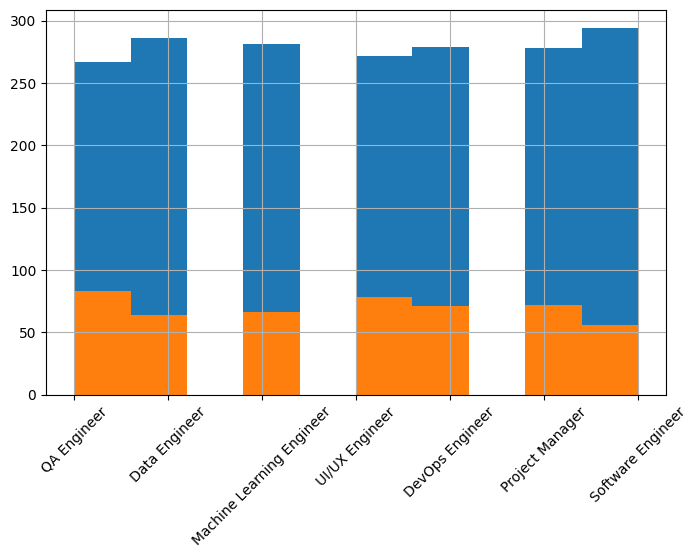

In [ ]:
plt.figure(figsize=(8, 5))

y_train.hist()
y_test.hist()

plt.xticks(rotation=45)
plt.show()

## 7. Model Evaluation


In [ ]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

Accuracy score is:  0.8326530612244898
Classes: (to help read Confusion Matrix)
 ['Data Engineer' 'DevOps Engineer' 'Machine Learning Engineer'
 'Project Manager' 'QA Engineer' 'Software Engineer' 'UI/UX Engineer']
Confusion Matrix: 
[[64  0  0  0  0  0  0]
 [18 46  0  2  2  2  1]
 [12  0 51  1  1  1  0]
 [ 1  0  0 71  0  0  0]
 [ 5  1  0  5 71  1  0]
 [ 7  0  0  7  2 38  2]
 [ 7  0  0  4  0  0 67]]
Classification Report: 
                           precision    recall  f1-score   support

            Data Engineer       0.56      1.00      0.72        64
          DevOps Engineer       0.98      0.65      0.78        71
Machine Learning Engineer       1.00      0.77      0.87        66
          Project Manager       0.79      0.99      0.88        72
              QA Engineer       0.93      0.86      0.89        83
        Software Engineer       0.90      0.68      0.78        56
           UI/UX Engineer       0.96      0.86      0.91        78

                 accuracy          

**Our accuracy score is 83% which is acceptable.**

In [ ]:
# Preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove tabulation and punctuation
    text = re.sub('[^\w\s]', ' ', text)

    # Remove digits
    text = re.sub('\d+', '', text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_text = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(lemmatized_text)

    return text

# Function for predicting job title
def predict_job_title(job_description):
    # Preprocess the job description
    preprocessed_description = preprocess_text(job_description)

    ## Converting text to features
    # vectorizer = TfidfVectorizer()

    # Vectorize the preprocessed job description
    description_vector = vectorizer.transform([preprocessed_description])

    # Predict the job title
    predicted_title = clf.predict(description_vector)

    return predicted_title[0]

# Example usage:
# job_description = "Your new job description goes here."
# predicted_title = predict_job_title(job_description)

des1 = """
We're seeking a to craft exceptional user experiences. Responsibilities include designing intuitive interfaces, creating wireframes, conducting user research, and collaborating with developers. Requirements include a degree in Design or a related field, proficiency in design tools (e.g., Adobe XD, Figma), and a strong grasp of user-centered design principles. Join us to shape visually stunning and user-friendly digital products that meet user needs.

Location: [City, State]
"""

print(f"{predict_job_title(des1)}")

UI/UX Engineer
